In [ ]:
# Instalar SimPEG y otras dependencias
!pip install simpeg numpy matplotlib scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.1/495.1 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 12.9 MB/s eta 0:00:00
  Created wheel for simpeg: filename=simpeg-0.23.0-py3-none-any.whl size=572253 sha256=7ac3901e365abb4209791bead8960d46d5e5fe93604dc0496244f1c344550c28
  Stored in directory: /root/.cache/pip/wheels/e3/0a/2e/94a1895a71964b1c21948ec0f640374242c24a9a3073346172
  Created wheel for pymatsolver: filename=pymatsolver-0.3.1-py3-none-any.whl size=16653 sha256=c40423f1e87c12bf1f5413f7cad97fd7c446749b92d0c2f9a68a9e4

In [1]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib.colors import LogNorm
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.linalg import lstsq


## MODELO 1D

In [2]:
        #Modelo 1D
# Definir el modelo de 3 capas
capas = [
    {"resistividad": 50, "espesor": 10},  # Suelo
    {"resistividad": 20, "espesor": 30},  # Arcilla
    {"resistividad": 70, "espesor": 10}  # Arenisca con agua
]
# Crear un arreglo de profundidades y resistividades
d = np.cumsum([capa["espesor"] for capa in capas[:-1]])
d = np.insert(d, 0, 0)  # Agregar la superficie
P = np.array([capa["resistividad"] for capa in capas])
# Generar datos sintéticos de resistividad aparente
np.random.seed(10)  # Para reproducibilidad
d1 = np.linspace(1, 50, 50)  # Profundidades de observación
Pa = np.zeros_like(d1)  # Inicializar array de resistividades aparentes
for i in range(len(capas)):
    mask = (d1 >= d[i]) & (d1 < d[i + 1] if i < len(capas)-1  else True)
    Pa[mask] = capas[i]["resistividad"]
# Agregar 30% de ruido aleatorio
ruido = 0.3 * Pa * np.random.normal(0, 1, Pa.shape)
Par = Pa + ruido
# Método 1: Promedios móviles
ventana = 5  # Tamaño de la ventana
P_mv = np.convolve(Par, np.ones(ventana)/ventana, mode='same')
# Método 2: Savitzky-Golay
P_savgol = savgol_filter(Par, window_length=5, polyorder=2)



In [3]:
def graficar_capas(d1, Pa, titulo):
    # Crear una malla para la gráfica
    X = np.arange(1, 51)  # Eje X de 1 en 1
    Y = d1  # Profundidades (eje Y)
    X, Y = np.meshgrid(X, Y)  # Crear una malla para la gráfica
    # Crear la figura
    plt.figure()
    # Graficar la resistividad aparente como una barra de color
    plt.pcolormesh(X, Y, np.tile(Pa, (len(X), 1)).T, shading='auto', cmap='viridis')
    # Añadir barra de color
    cbar = plt.colorbar(label="Resistividad Aparente (ρa) [Ω·m]")
    # Añadir etiquetas y título
    plt.xlabel("X")
    plt.ylabel("Profundidad (Y) [m]")
    plt.title(titulo)
    plt.gca().invert_yaxis()  # Invertir el eje Y para que la profundidad aumente hacia abajo
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()


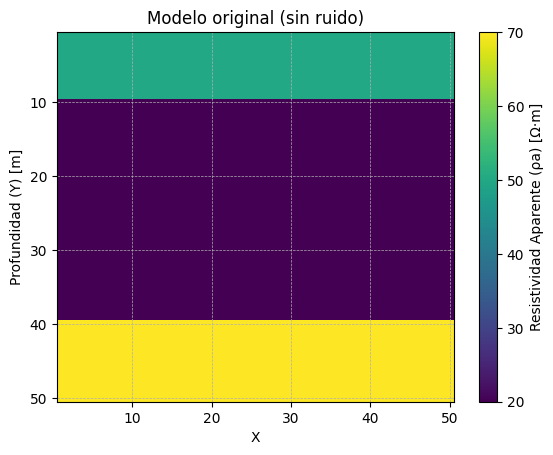

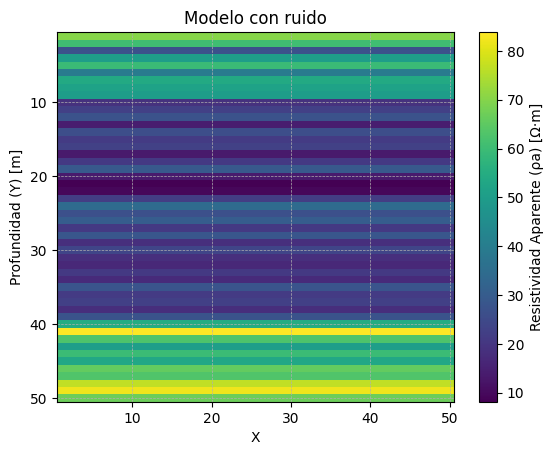

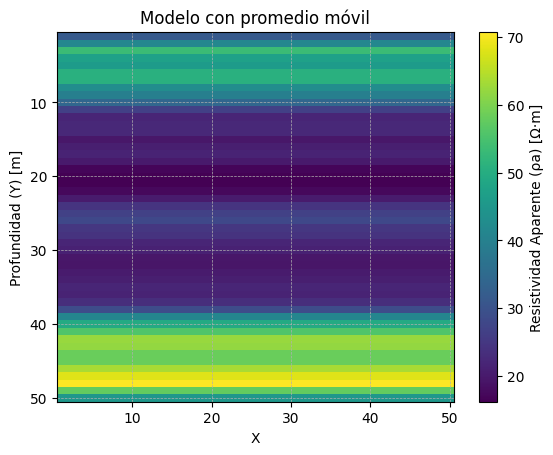

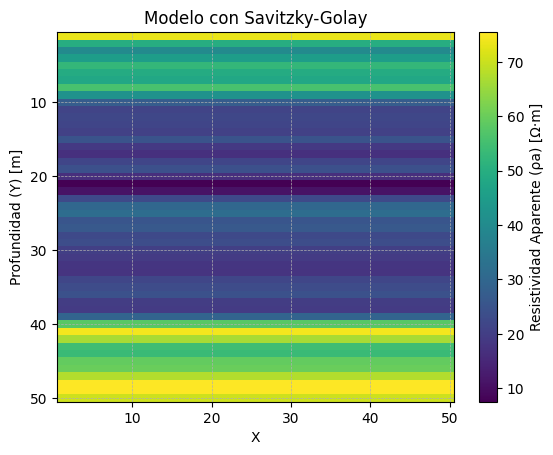

In [4]:
graficar_capas(d1, Pa, "Modelo original (sin ruido)")
graficar_capas(d1, Par, "Modelo con ruido")
graficar_capas(d1, P_mv, "Modelo con promedio móvil")
graficar_capas(d1, P_savgol, "Modelo con Savitzky-Golay")

###Curvas de resistitvidad aparente

In [5]:
def GraficaCR(AB2, resistividad_aparente, titulo):
  # Graficar en escala bilogarítmica
  plt.figure()
  plt.loglog(AB2, resistividad_aparente, marker="o", linestyle="-", color="blue", label="Curva de Resistividad Aparente")

  # Añadir etiquetas y título
  plt.xlabel("AB/2 [m]")
  plt.ylabel("Resistividad Aparente (ρa) [Ω·m])")
  plt.title(titulo)
  plt.legend()
  plt.grid(True, which="both", linestyle="--", linewidth=0.5)
  plt.show()

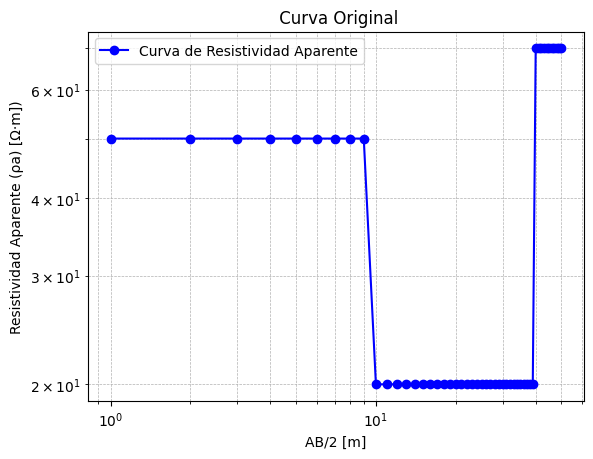

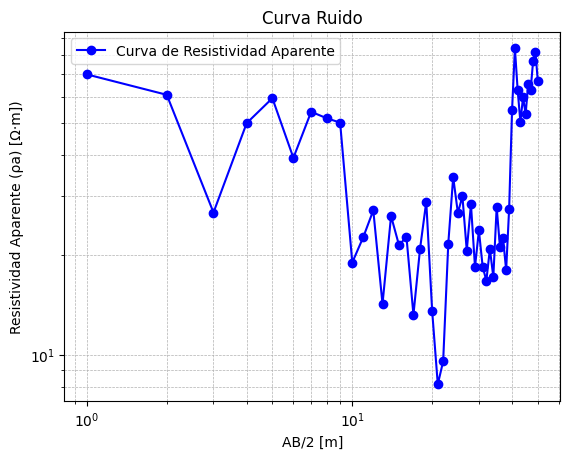

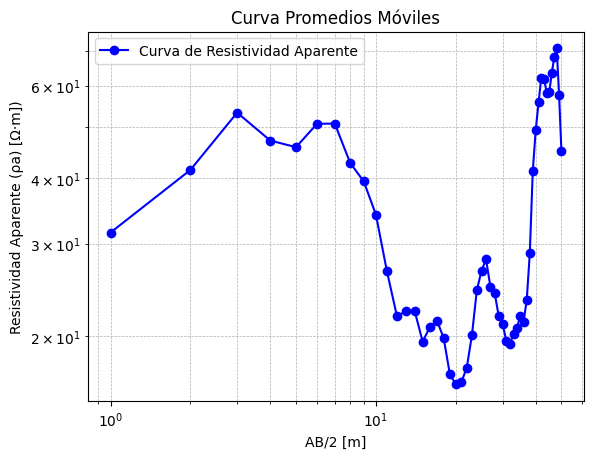

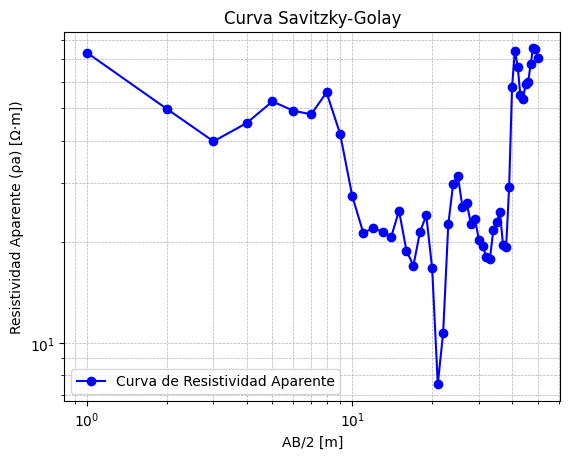

In [6]:
#dado que es Schlumberger asumiremos que d=AB/2
GraficaCR(d1, Pa, " Curva Original")
GraficaCR(d1, Par, "Curva Ruido")
GraficaCR(d1, P_mv, "Curva Promedios Móviles")
GraficaCR(d1, P_savgol, "Curva Savitzky-Golay")

In [8]:
# Función de error para la inversión con interpolación
def inversion_resistividad(P_estimada, d, Pa):
    # Crear una función de interpolación logarítmica de resistividad
    f_interp = interp1d(d, np.log10(P_estimada), bounds_error=False, fill_value="extrapolate")

    # Calcular resistividad aparente interpolada
    Pa_modelo = 10**f_interp(d1)

    return Pa_modelo - Pa  # Diferencia con datos reales
# Ajustar inversión con restricciones
P_invertidos = {}
for nombre, datos in zip(["Original", "Ruido", "Promedio Móvil", "Savitzky-Golay"], [Pa, Par, P_mv, P_savgol]):
    resultado = least_squares(inversion_resistividad, P, args=(d, datos), bounds=(1, 10000))
    P_invertidos[nombre] = resultado.x

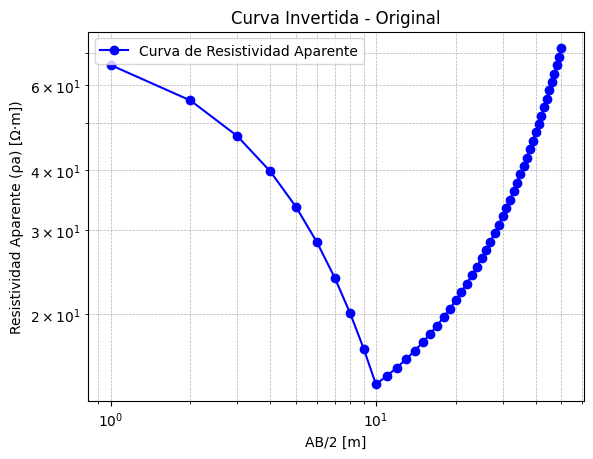

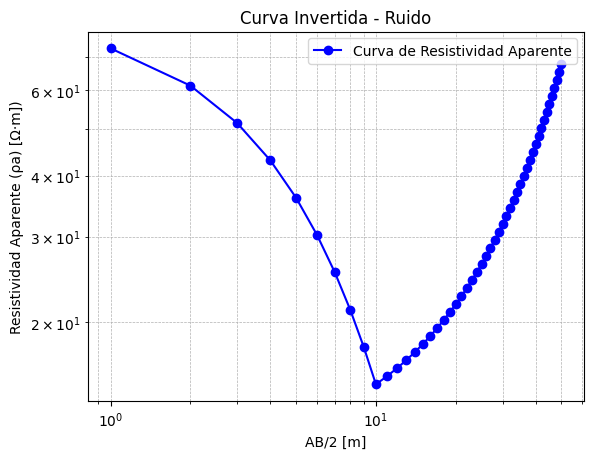

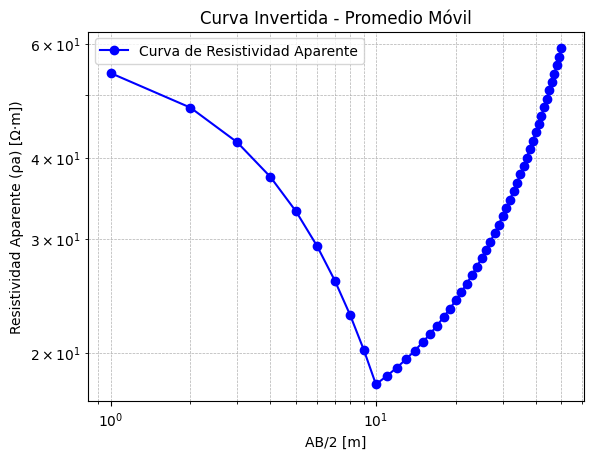

In [9]:
# Graficar solo los modelos invertidos
for nombre, P_inv in P_invertidos.items():
    Pa_invertida = 10**interp1d(d, np.log10(P_inv), bounds_error=False, fill_value="extrapolate")(d1)

    # Usar la función GraficaCR para graficar cada modelo invertido
    GraficaCR(d1, Pa_invertida, f"Curva Invertida - {nombre}")


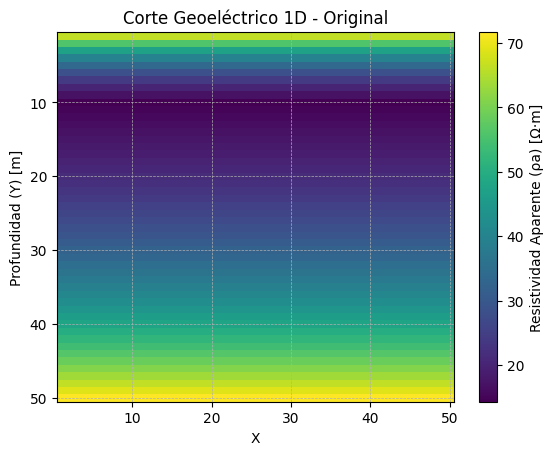

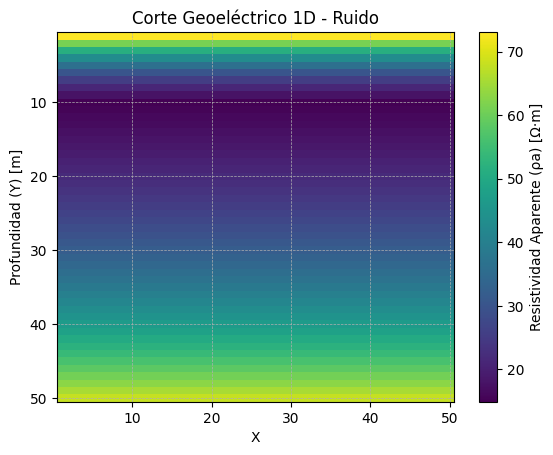

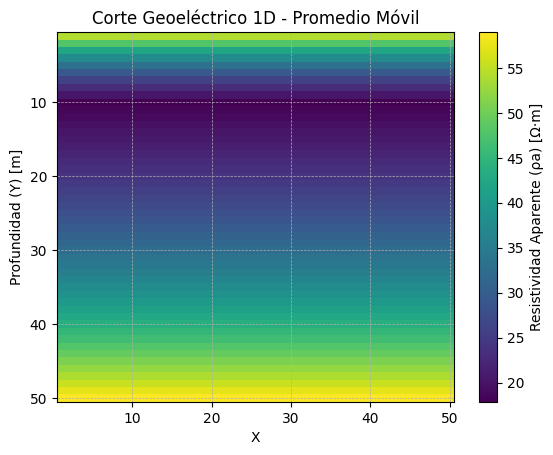

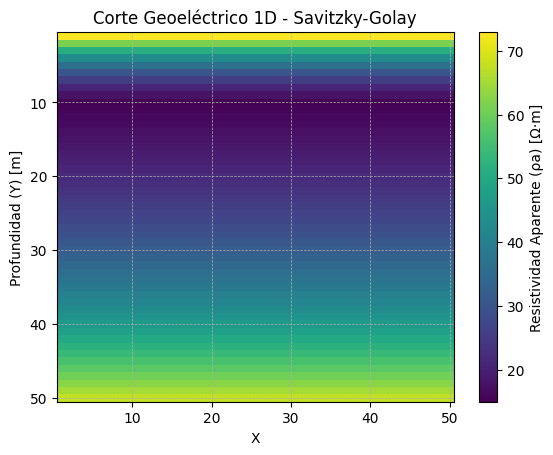

In [10]:
# Graficar los cortes geeléctricos 1D de los modelos invertidos
for nombre, P_inv in P_invertidos.items():
    Pa_invertida = 10**interp1d(d, np.log10(P_inv), bounds_error=False, fill_value="extrapolate")(d1)

    # Llamada a la función graficar_capas con los datos invertidos
    graficar_capas(d1, Pa_invertida, f"Corte Geoeléctrico 1D - {nombre}")

# MODELO 2D

In [11]:
## MODELO 2D
# Definir las dimensiones del modelo
profundidades = np.linspace(0, 30, 100)  # Eje Y: Profundidades de 0 a 30 metros
distancias = np.linspace(0, 50, 100)    # Eje X: Distancia total de la tomografía de 0 a 50 metros
# Crear una malla para las distancias y profundidades
X, Y = np.meshgrid(distancias, profundidades)
# Inicializar la resistividad con un valor constante
Pa = np.ones((100, 100)) * 500  # Resistividad base de 500 Ohm*m
Pa[25:75, 25:75] = 100  # Zona de baja resistividad (50 Ohm*m)
# Agregar 30% de ruido aleatorio
ruido = 0.3 * Pa * np.random.normal(0, 1, Pa.shape)  # Ruido proporcional a la resistividad
Par = Pa + ruido  # Datos con ruido
# Método 1: Promedios móviles
ventana = 5  # Tamaño de la ventana
P_mv = np.apply_along_axis(lambda m: np.convolve(m, np.ones(ventana)/ventana, mode='same'), axis=1, arr=Par)
# Método 2: Savitzky-Golay
P_savgol = savgol_filter(Par, window_length=5, polyorder=2, axis=1)  # Filtro Savitzky-Golay


In [14]:
# Graficar curvas
def CResisitvidad(d, P, titulo):
    plt.figure(figsize=(10, 6))
    plt.loglog(d, P[:, 50], label='Resitivdad', linewidth=2, color='blue')
    plt.xlabel('Profundidad (m)')
    plt.ylabel('Resistividad (Ohm*m)')
    plt.title(titulo)
    plt.legend()
    plt.grid(True)
    plt.show()

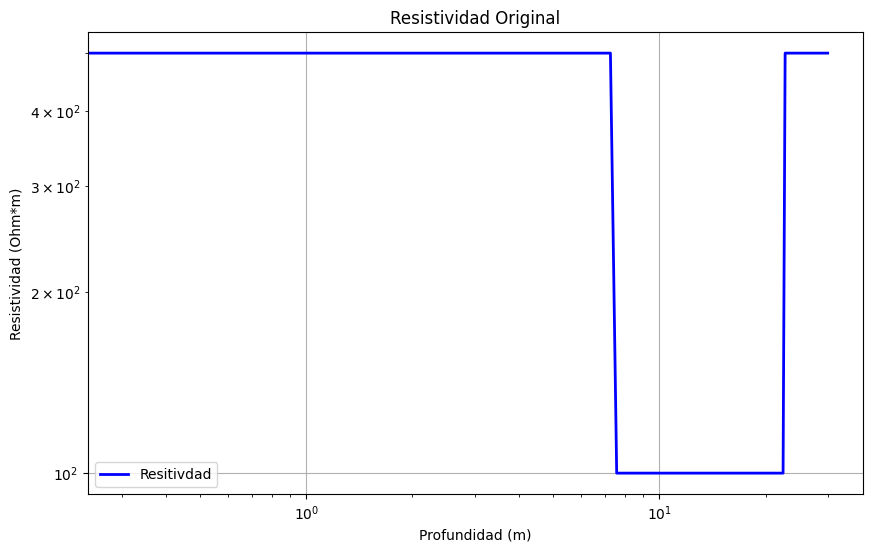

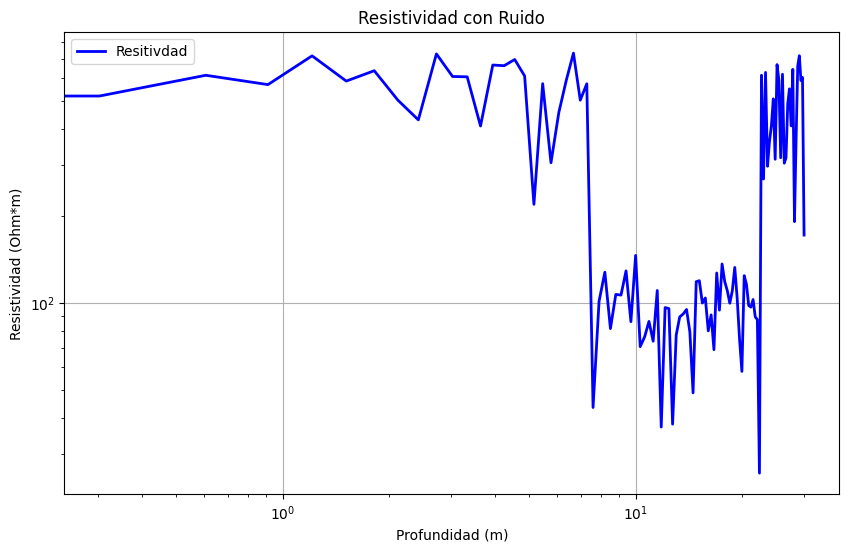

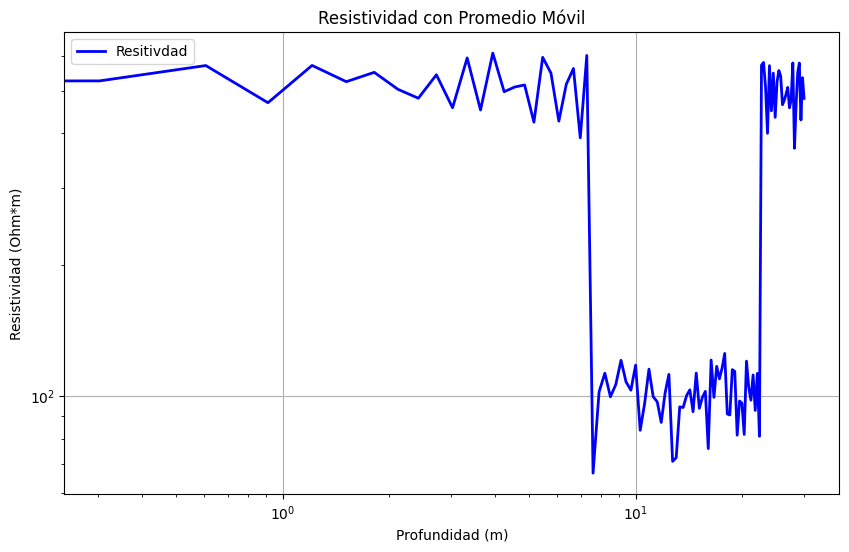

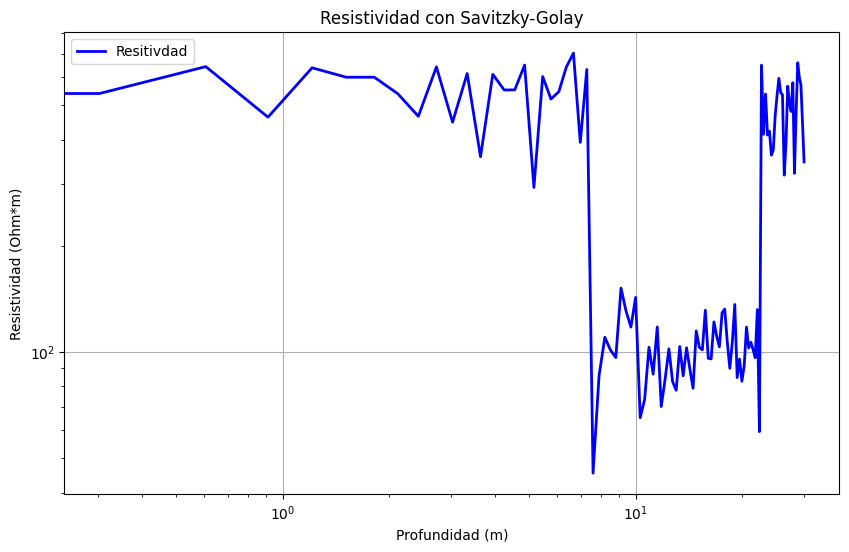

In [15]:
# Graficar los diferentes modelos en función de la profundidad en un corte a lo largo de la distancia
CResisitvidad(profundidades, Pa, "Resistividad Original")
CResisitvidad(profundidades, Par, "Resistividad con Ruido")
CResisitvidad(profundidades, P_mv, "Resistividad con Promedio Móvil")
CResisitvidad(profundidades, P_savgol, "Resistividad con Savitzky-Golay")

In [25]:
def Gradica2D(Z, title):
    plt.figure()
    cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(cp, label='Resistividad Aparente (Ohm*m)')
    plt.xlabel('Distancia (m)')
    plt.ylabel('Profundidad (m)')
    plt.gca().invert_yaxis()  # Invertir el eje Y para que la profundidad aumente hacia abajo
    plt.title(title)
    plt.grid(True)
    plt.show()

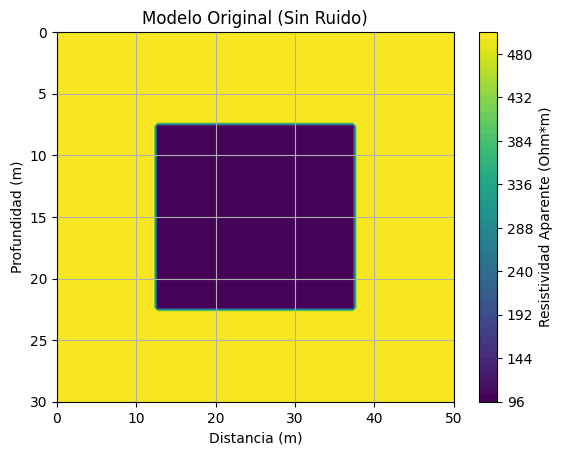

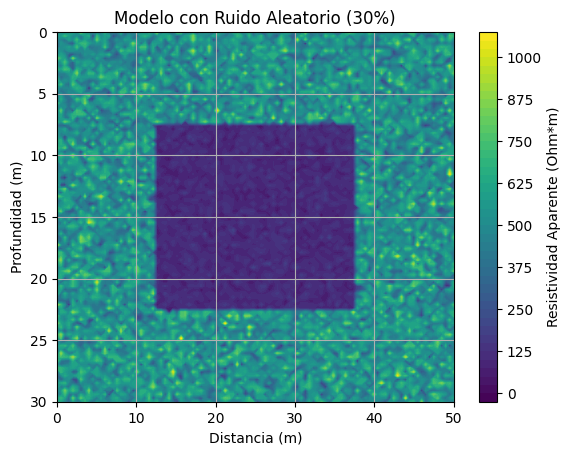

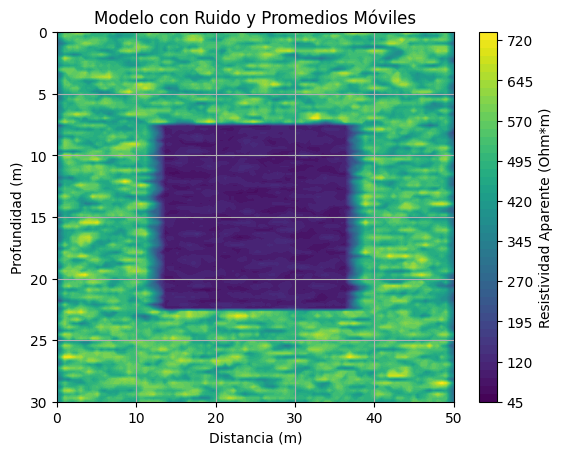

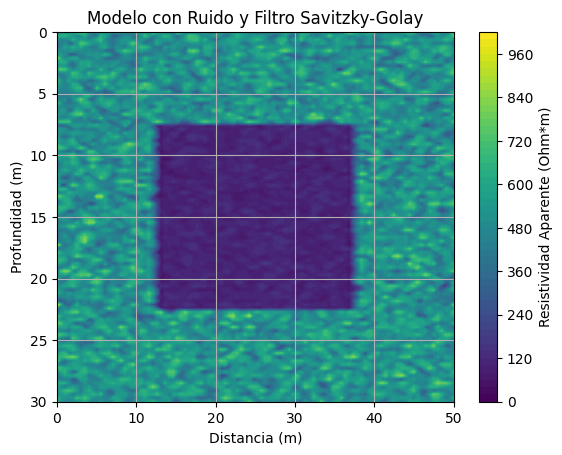

In [26]:
Gradica2D(Pa, 'Modelo Original (Sin Ruido)')
Gradica2D(Par, 'Modelo con Ruido Aleatorio (30%)')
Gradica2D(P_mv, 'Modelo con Ruido y Promedios Móviles')
Gradica2D(P_savgol, 'Modelo con Ruido y Filtro Savitzky-Golay')

In [ ]:
# Función de error para la inversión con interpolación
def inversion_resistividad(P_estimada, d, Pa):
    # Crear una función de interpolación logarítmica de resistividad
    f_interp = interp1d(d, np.log10(P_estimada), bounds_error=False, fill_value="extrapolate")
    # Calcular resistividad aparente interpolada
    Pa_modelo = 10**f_interp(d)
    return Pa_modelo - Pa  # Diferencia con datos reales

# Aplicar la inversión a cada columna de la sección 2D
def inversion_2D(datos):
    # Inicializar la matriz de resistividades invertidas
    datos_invertidos = np.zeros_like(datos)
    # Aplicar la inversión a cada columna
    for i in range(datos.shape[1]):
        datos_columna = datos[:, i]
        # Inicializar la estimación inicial (puede ser un valor constante)
        P_inicial = np.ones_like(profundidades) * 500  # Estimación inicial de 500 Ohm*m
        # Ajustar la inversión
        resultado = least_squares(inversion_resistividad, P_inicial, args=(profundidades, datos_columna), bounds=(1, 10000))
        # Guardar el resultado
        datos_invertidos[:, i] = resultado.x
    return datos_invertidos

# Aplicar la inversión a cada conjunto de datos
Pa_inv_2D = inversion_2D(Pa)
Par_inv_2D = inversion_2D(Par)
P_mv_inv_2D = inversion_2D(P_mv)
P_savgol_inv_2D = inversion_2D(P_savgol)

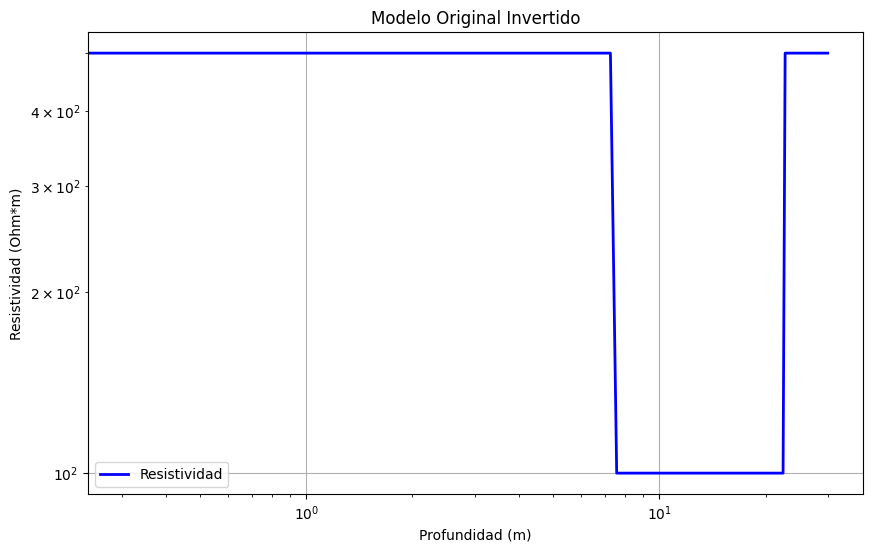

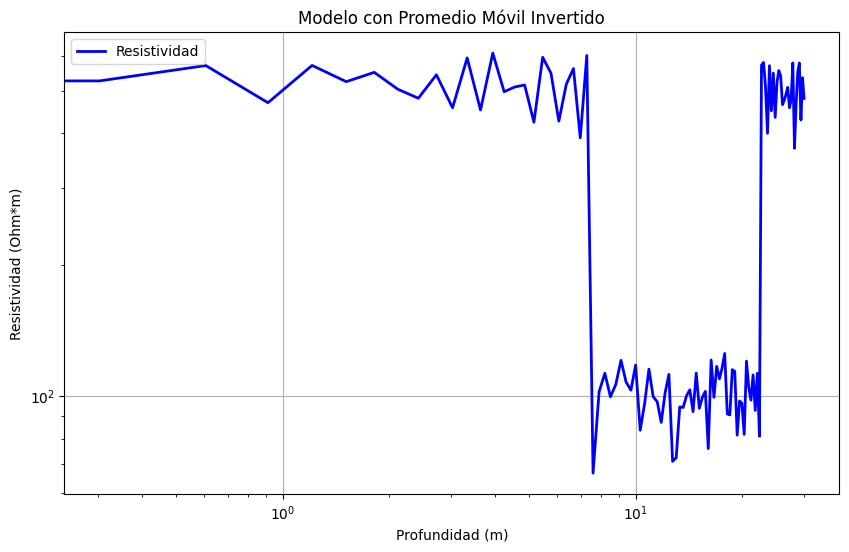

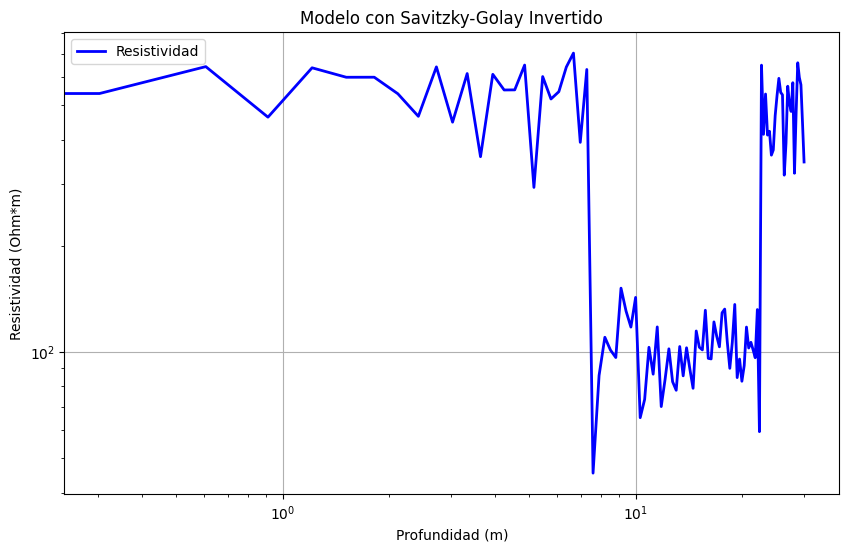

In [29]:
# Graficar las curvas de resistividad invertida para cada modelo
def CResisitvidad_Invertida(d, P, titulo):
    plt.figure(figsize=(10, 6))
    plt.loglog(d, P[:, 50], label='Resistividad', linewidth=2, color='blue')  # Usamos la columna 50 para el corte
    plt.xlabel('Profundidad (m)')
    plt.ylabel('Resistividad (Ohm*m)')
    plt.title(titulo)
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficar las curvas de resistividad invertida de cada modelo
CResisitvidad_Invertida(profundidades, Pa_inv_2D, "Modelo Original Invertido")
CResisitvidad_Invertida(profundidades, Par_inv_2D, "Modelo con Ruido Invertido")
CResisitvidad_Invertida(profundidades, P_mv_inv_2D, "Modelo con Promedio Móvil Invertido")
CResisitvidad_Invertida(profundidades, P_savgol_inv_2D, "Modelo con Savitzky-Golay Invertido")


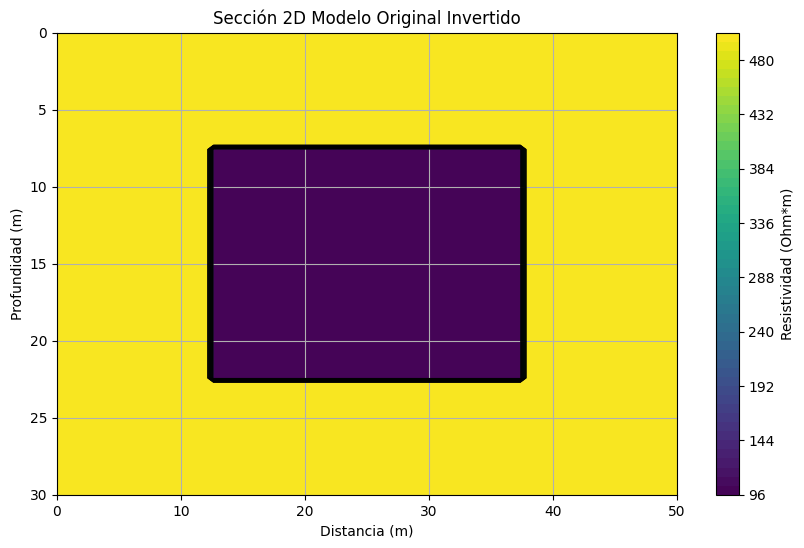

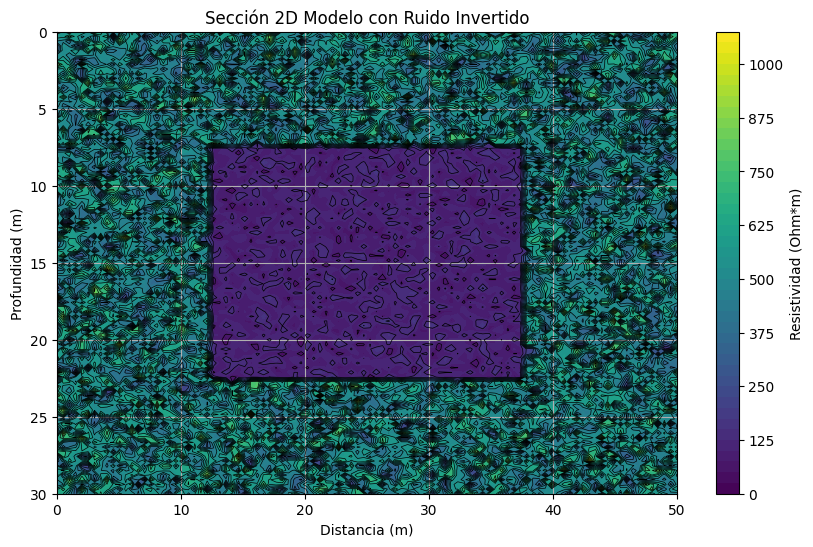

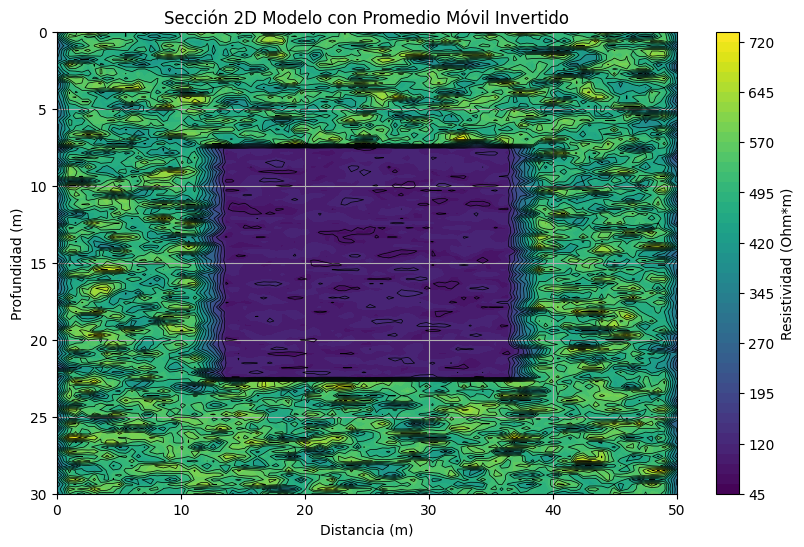

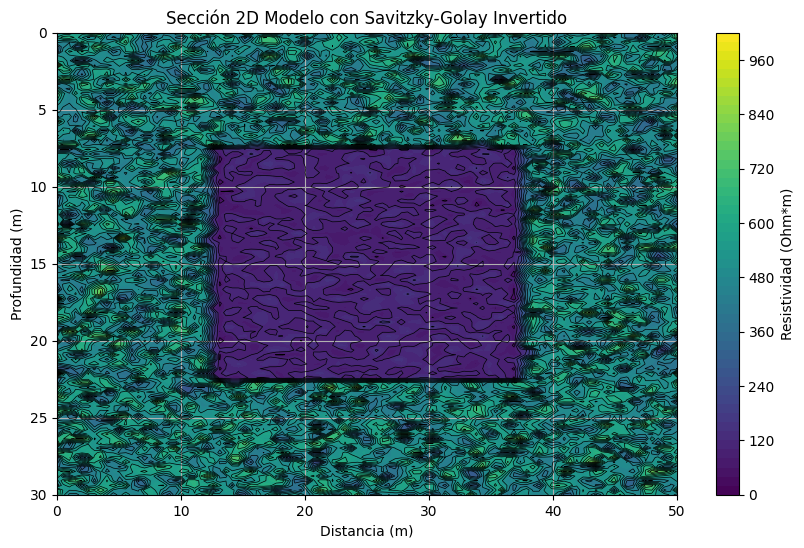

In [28]:
def graficar_seccion_2D_con_contornos(X, Y, resistividad, titulo):
    plt.figure(figsize=(10, 6))
    # Graficar con contornos
    cp = plt.contourf(X, Y, resistividad, levels=50, cmap='viridis')  # Contornos de resistividad
    plt.colorbar(cp, label='Resistividad (Ohm*m)')  # Barra de colores
    plt.contour(X, Y, resistividad, levels=20, colors='k', linewidths=0.5)  # Líneas de contorno en negro
    plt.xlabel('Distancia (m)')
    plt.ylabel('Profundidad (m)')
    plt.gca().invert_yaxis()  # Invertir el eje Y para que la profundidad aumente hacia abajo
    plt.title(titulo)
    plt.grid(True)
    plt.show()

# Graficar las secciones 2D con contornos para cada modelo invertido
graficar_seccion_2D_con_contornos(X, Y, Pa_inv_2D, 'Sección 2D Modelo Original Invertido')
graficar_seccion_2D_con_contornos(X, Y, Par_inv_2D, 'Sección 2D Modelo con Ruido Invertido')
graficar_seccion_2D_con_contornos(X, Y, P_mv_inv_2D, 'Sección 2D Modelo con Promedio Móvil Invertido')
graficar_seccion_2D_con_contornos(X, Y, P_savgol_inv_2D, 'Sección 2D Modelo con Savitzky-Golay Invertido')